# Анализ лояльности пользователей Яндекс Афиши

## Цель и задачи
Цель: провести исследовательский анализ данных, чтобы понять, какие пользователи с большей вероятностью возвращаются на платформу и делают заказы повторно

## Задачи:
1. Загрузить данные из базы данных и познакомиться с их содержимым.
2. Провести предобработку данных.
3. Провести исследовательский анализ данных:
    - изучить данные более детально;
    - изучить взаимосвязь поведения пользователей с данными в датасете.
4. Сформулировать выводы по проведённому анализу.

## Данные
Для анализа поступили данные из базы данных *afisha* о заказах пользователей на платформе Яндекс Афиша в период с июня по ноябрь 2024 года. Данные, выгружаемые из базы данных, состоят из датасета с полями:
- *user_id* — уникальный идентификатор пользователя, совершившего заказ;
- *device_type_canonical* — тип устройства, с которого был оформлен заказ ( mobile — мобильные устройства, - desktop — стационарные);
- *order_id* — уникальный идентификатор заказа;
- *order_dt* — дата создания заказа;
- *order_ts* — дата и время создания заказа;
- *currency_code* — валюта оплаты;
- *revenue* — выручка от заказа;
- *tickets_count* — количество купленных билетов;
- *days_since_prev* — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- *event_id* — уникальный идентификатор мероприятия;
- *service_name* — название билетного оператора;
- *event_type_main* — основной тип мероприятия (театральная постановка, концерт и так далее);
- *region_name* — название региона, в котором прошло мероприятие;
- *city_name* — название города, в котором прошло мероприятие.

## Структура проекта

1. Выгрузка данных из SQL и знакомство с ними.
2. Предобработка данных.
3. Создание профиля пользователя
4. Исследовательский анализ данных.
5. Итоговые выводы.

*Автор:* Самохвал Ксения

## Выгрузка данных из SQL и знакомство с ними.

Для начала загрузим необходимые библиотеки: для выгрузки данных из SQL sqlalchemy, для взаимодействия с датасетами библиотеку pandas, для работы с визуализацией данных библиотеки matplotlib и seaborn, а также библиотеку phik для расчета коэффициента корреляции данных. 

In [1]:
#Загружаем библиотеки
#!pip install sqlalchemy
#!pip install psycopg2
!pip install phik

# Импортируем библиотеки для работы с данными
import pandas as pd
from sqlalchemy import create_engine 
from dotenv import load_dotenv
import os

# Загружаем библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем библиотеку для расчёта коэффициента корреляции
from phik import phik_matrix

Создадим подключение к базе данных *afisha*:

In [2]:
load_dotenv() # автоматически ищет .env в текущей директории

# Создаем подключение
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    os.getenv('DB_USER'),
    os.getenv('DB_PASSWORD'),
    os.getenv('DB_HOST'),
    os.getenv('DB_PORT'),
    os.getenv('DB_NAME'),
)

engine = create_engine(connection_string) 

Напишем запрос для выгрузки необходимых данных и запишем данные в датафрейм *df* для последующей работы с ними.

In [3]:
#SQL-запрос для выгрузки
query = '''
SELECT user_id,
      device_type_canonical,
      order_id,
      created_dt_msk as order_dt,
      created_ts_msk as order_ts,
      currency_code,
      revenue,
      tickets_count,
      extract(day from (created_dt_msk - lag(created_dt_msk) OVER(partition by user_id order by created_dt_msk))) AS days_since_prev,
      event_id,
      service_name,
      event_type_main,
      region_name,
      city_name
FROM afisha.purchases p 
join afisha.events e using(event_id)
join afisha.city c using(city_id)
join afisha.regions r using(region_id)
WHERE (device_type_canonical = 'mobile' or device_type_canonical='desktop') and event_type_main!='фильм'
ORDER BY user_id
'''

# Создаем датафрейм с выгруженными данными
try:
    df = pd.read_sql_query(query, con=engine)
except:
    display('Ошибка подключения к базе данных')

Познакомимся с данными датафрейма - с помощью метода head() выведем 5 первых строк, а с помощью метода info() получим информацию о нем.

In [4]:
#Выводим первые строки датафрейма
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,service_name,event_type_main,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,Край билетов,театр,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,Мой билет,выставки,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,За билетом!,другое,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,Лови билет!,другое,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,Билеты без проблем,стендап,Озернинский край,Родниковецк


In [5]:
#Выводим информацию о датафрейме
df.info()
strokes = df.shape[0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  service_name           290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  region_name            290611 non-null  obje

Датафрейм содержит 14 столбцов и 290611 строк, в которых представлена информация о заказах пользователе Яндекс Афиши.

После первичного анализа данных можно сделать следующие выводы:

- Названия столбцов предоставлены в одном формате, соответствующему snake case.
- Все представленные данные, содержащие числовые значения хранятся в типах данных int64 и float64, а данные, содержащие строковые значения, хранятся в типе данных object. Значения некоторых столбцах датафлейма по совему характеру не могут быть слишком большими — размерность этих данных можно оптимизировать. Также стоит обратить внимание на тип данных столбца `days_since_prev`, тип float64 применен к нему в связи с пропусками.
- Пропуски содержатся только в столбце `days_since_prev`. Однако следует проверить и другие столбцы: в них могут встречаться значения-индикаторы, которые будут говорить об отсутствии данных.
Судя по первому знакомству с данными, значения в столбцах соответствуют своему описанию.

## Предобработка данных
### Перевод выручки в единую валюту
Так как датасет содержит информацию о покупках билетов в разных валютах, то для удобства дальнейшего анализа имеет смысл создать столбец, хранящий сумму выручки в одной валюте. Для этого воспользуемся датасетом `final_tickets_tenge_df.csv`, содержащим в себе информацию о курсе валют на необходимый временной промежуток. Создадим датафрейм `df_tenge` c этими данными.

In [6]:
# Создаем датафрейм
df_tenge = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

# Выводим первые строки датафрейма
df_tenge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


В датасете df_tenge дата хранится в столбце `data` с типом данных object, изменим тип данных на подходящий:

In [7]:
df_tenge['data'] = df_tenge['data'].astype('datetime64[ns]')

Теперь напишем функцию, которая на основе курса валют позволит рассчитать выручку в рублях для всех данных:

In [8]:
# Функция расчета выручки в рублях
def change_currency(order):
    if order['currency_code'] == 'kzt':
        curs = df_tenge[df_tenge['data']==order['order_dt']]['curs'].mean()
        return round(order['revenue']/curs*100,2)
    else:
        return order['revenue']
        
# Применяем функцию на датафрейме 
df['revenue_rub'] = df.apply(change_currency, axis=1)
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,service_name,event_type_main,region_name,city_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,Край билетов,театр,Каменевский регион,Глиногорск,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,Мой билет,выставки,Каменевский регион,Глиногорск,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,За билетом!,другое,Каменевский регион,Глиногорск,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,Лови билет!,другое,Североярская область,Озёрск,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,Билеты без проблем,стендап,Озернинский край,Родниковецк,1390.41


В датафрейме `df` появился столбец `revenue_rub`, в котором отображена выручка для каждого заказа в рублях, округленная до копеек.

### Проверим наличие пропусков в данных

При первичном анализе данных датасета пропуски были обнаружены только в столбце `days_since_prev`. Узнаем абсолютное и относительно значение этих пропусков.

In [9]:
#Рассчитываем количество пропусков
df.isna().sum()

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
service_name                 0
event_type_main              0
region_name                  0
city_name                    0
revenue_rub                  0
dtype: int64

In [10]:
#Рассчитываем долю пропусков 
df.isna().sum()/df.shape[0]

user_id                  0.000000
device_type_canonical    0.000000
order_id                 0.000000
order_dt                 0.000000
order_ts                 0.000000
currency_code            0.000000
revenue                  0.000000
tickets_count            0.000000
days_since_prev          0.075472
event_id                 0.000000
service_name             0.000000
event_type_main          0.000000
region_name              0.000000
city_name                0.000000
revenue_rub              0.000000
dtype: float64

Всего пропусков в столбце 21933, что составляет 7.5% от общего объема. 

По описанию данных этот столбец может содержать пропуск если клиент делает заказ впервые, поэтому такие значения скорее всего не являются ошибочными. Оставим пропуски в этом столбце для того чтобы измененнные значения не повлияли на дальнейший анализ.

### Оптимизация типов данных

Численные данные, хранящиеся в рнекоторых столбцах датафрейма по своему характеру не могут быть большими, поэтому для более эффективной работы с данными стоит привести типы данных к более подходящим.

Оптимизируем типы данных в столбцах датафрейма, используя метод `pd.to_numeric` и его параметр `downcast` со значением подходящего типа, таким образом сможем для каждого столбца подобрать необходимую разрядность. Столбец days_since_prev не содержит больших значений, однако оптимизировать тип данных в нем нельзя, так как в нем содержатся пропуски.

In [11]:
# Применяем метод to_numeric для оптимизации типов данных
df['order_id'] = pd.to_numeric(df['order_id'], downcast='integer')
df['event_id'] = pd.to_numeric(df['event_id'], downcast='integer')
df['tickets_count'] = pd.to_numeric(df['tickets_count'], downcast='integer')
df['revenue'] = pd.to_numeric(df['revenue'], downcast='float')
df['revenue_rub'] = pd.to_numeric(df['revenue_rub'], downcast='float')

Столбцы, хранящие дату и время, также можно оптимизировать, так как имеющийся тип данных поддерживает формат времени с точностью до наносекунд, а в текущем контексте такая точность не нужна. Для оптимизации используем метод `astype` с указанием необходимого типа данных.

In [12]:
# Применяем метод astype на столбцах с датой
df['order_dt'] = df['order_dt'].astype('datetime64[s]')
df['order_ts'] = df['order_ts'].astype('datetime64[s]')

In [13]:
# Проверим изменения в типах данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype        
---  ------                 --------------   -----        
 0   user_id                290611 non-null  object       
 1   device_type_canonical  290611 non-null  object       
 2   order_id               290611 non-null  int32        
 3   order_dt               290611 non-null  datetime64[s]
 4   order_ts               290611 non-null  datetime64[s]
 5   currency_code          290611 non-null  object       
 6   revenue                290611 non-null  float64      
 7   tickets_count          290611 non-null  int8         
 8   days_since_prev        268678 non-null  float64      
 9   event_id               290611 non-null  int32        
 10  service_name           290611 non-null  object       
 11  event_type_main        290611 non-null  object       
 12  region_name            290611 non-null  object       
 13 

Типы данных оптимизированы с понижением размерности целочисленных данных, а также с уменьшением точности данных, хранящих дату и время.

### Дубликаты и ошибки в данных

Проверим наличие дубликатов в данных. Начнем с явных дубликатов

In [14]:
#Проверяем полные дублкикаты в датафрейме 
df.duplicated().sum()

np.int64(0)

В датафрейме нет полных дубликатов строк.

Проверим неявные дубликаты значения по order_id

In [15]:
#Проверяем неявные дублкикаты в датафрейме по order_id
display(df.duplicated(subset='order_id').sum())

np.int64(0)

Дубликатов по order_id не встречается, а значит каждая строка соответствует уникальному заказу.

Стоит проверить также возможные технические дубликаты, где одному заказу присвоились разные номера заказов:

In [16]:
#Проверяем неявные дубликаты по user_id и order_ts
display(df.duplicated(subset=['user_id','order_ts']).sum())

np.int64(170)

Найдено 170 возможных дубликатов, однако такие заказы могут быть быстрыми повторными заказами от одного пользователя, проверим их по составу заказа:

In [17]:
#Проверяем неявные дубликаты по user_id и order_ts
display(df.duplicated(subset=['user_id','order_ts','revenue_rub','tickets_count']).sum())

np.int64(46)

В датафрейме есть 46 записей, которые идентичны по составу и времени заказа, но записаны под разными номерами, их стоит удалить

In [18]:
df = df.drop_duplicates(subset=['user_id', 'order_ts', 'revenue_rub', 'tickets_count'], keep='first')

Для выявления неявных дубликатов проверим также значения категориальных столбцов на ошибки в данных.

In [19]:
# Функция для вывода уникальных значений категориальных столбцов
def unique_values(columns):
    for column in columns:
        print(f'Уникальные значения столбца {column}:')
        print(df[column].sort_values().unique(), "\n")
        print(df[column].value_counts(), "\n")

unique_values(['device_type_canonical','currency_code','service_name','event_type_main'])

Уникальные значения столбца device_type_canonical:
['desktop' 'mobile'] 

device_type_canonical
mobile     232459
desktop     58106
Name: count, dtype: int64 

Уникальные значения столбца currency_code:
['kzt' 'rub'] 

currency_code
rub    285497
kzt      5068
Name: count, dtype: int64 

Уникальные значения столбца service_name:
['Crazy ticket!' 'Show_ticket' 'Билет по телефону' 'Билеты без проблем'
 'Билеты в интернете' 'Билеты в руки' 'Быстробилет' 'Быстрый кассир'
 'Весь в билетах' 'Восьмёрка' 'Вперёд!' 'Выступления.ру'
 'Городской дом культуры' 'Дом культуры' 'Дырокол' 'За билетом!'
 'Зе Бест!' 'КарандашРУ' 'Кино билет' 'Край билетов' 'Лимоны'
 'Лови билет!' 'Лучшие билеты' 'Мир касс' 'Мой билет' 'Облачко'
 'Прачечная' 'Радио ticket' 'Реестр' 'Росбилет' 'Тебе билет!' 'Телебилет'
 'Тех билет' 'Цвет и билет' 'Шоу начинается!' 'Яблоко'] 

service_name
Билеты без проблем        63500
Лови билет!               41118
Билеты в руки             40334
Мой билет                 34834
Облачко

Записи в столбцах с номинальными данными выглядят корректно, все значения уникальны, однако в столбце `event_type_main` есть значение *'другое'*, что может быть заглушкой для пропусков.

Теперь изучим численные данные на наличие выбросов:

Статистическое описание столбца revenue_rub:
count    290565.000000
mean        982.373824
std        4702.713311
min         -90.760000
25%         116.990000
50%         359.370000
75%         822.610000
max      133023.890000
Name: revenue_rub, dtype: float64 



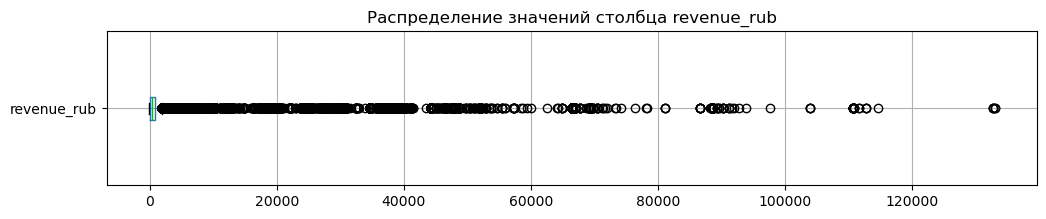

In [20]:
#Функция для описания численных данных
def describe_data(columns):
    for column in columns:
        print(f'Статистическое описание столбца {column}:')
        print(df[column].describe(), "\n")
        df.boxplot(column=column, vert=False, figsize=(12,2))
        plt.title(f'Распределение значений столбца {column}')
        plt.show()

#Выводим инфоомацию и диаграмму распределения столбца revenue_rub
describe_data(['revenue_rub'])

Минимальное значение выручки отрицательное, узнаем сколько всего существует таких записей:

In [21]:
#Рассчитываем абсолютное и относительное количество записей с отрицательной выручкой
display(df[df['revenue_rub']<0]['revenue'].count())
display(df[df['revenue_rub']<0]['revenue'].count()/df.shape[0])

np.int64(381)

np.float64(0.0013112384492282277)

Всего таких записей 381(0.1% от общего объема), скорее всего такие данные ошибочны, а значит их стоит удалить:

In [22]:
#Удаляем записи с отрицательной выручкой
df = df[df['revenue_rub']>=0]

Распределение значения выручки асимметричное, скошенное вправо. По гистограмме размаха видно, что большое количество значений можно считать выбросами, однако не все выбросы могут быть ошибочнымм, чтобы не сильно исказить анализ удалим выбросы, превышающие 99% других данных по значению

In [23]:
#Рассчитываем 99 процентиль
q_tc = df['revenue_rub'].quantile(0.99)
outliners_rev = df[df['revenue_rub']>=q_tc]
display(f'Общее количество выбросов: {outliners_rev.shape[0]}')
display(f'Доля выбросов: {outliners_rev.shape[0]/df.shape[0]}')

#Удаляем выбросы
df = df.loc[df['revenue_rub']<q_tc]

'Общее количество выбросов: 2909'

'Доля выбросов: 0.010024673999944863'

Теперь изучим стобец `tickets_count`

Статистическое описание столбца tickets_count:
count    287275.000000
mean          2.753877
std           1.172991
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64 



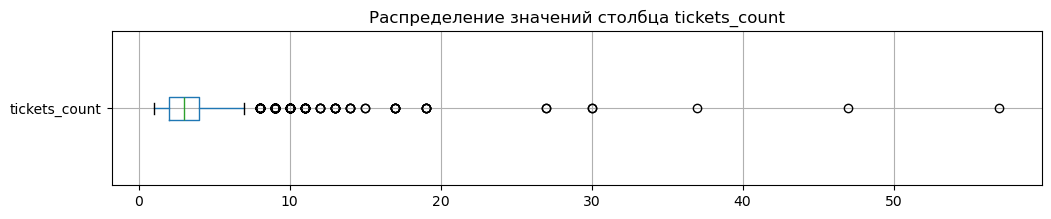

In [24]:
describe_data(['tickets_count'])

По статистическому описанию столбца tickets_count видно, что третий квартиль и максимальное значение имеют большую разницу, при этом среднее значение сильно ниже максимального, а значит в столбце есть выбросы, которые видно и на диаграмме распределения значений. 
Рассчитаем выбросы по межквартильному размаху их количество:

In [25]:
#Вычисляем первый и третий квартиль и IQR
q1_tc = df['tickets_count'].quantile(0.25)
q3_tc = df['tickets_count'].quantile(0.75)
iqr_tc = q3_tc-q1_tc

#Находим выбросы
outliners = df[(df['tickets_count']<=(q1_tc-1.5*iqr_tc)) | (df['tickets_count']>=(q3_tc+1.5*iqr_tc))]

#Рассчитвываем абсолютное и относительное количество выбросов
display(f'Всего выбросов: {outliners.shape[0]}')
display(f'Доля выбросов: {outliners.shape[0]/df.shape[0]}')

'Всего выбросов: 188'

'Доля выбросов: 0.00065442520233226'

Всего в столбце tickets_count 188 выбросов, что составляет 0.06% от общего объема данных столбца, такие значения могли быть вызваны ошибками или заменять неизвестные данные, однако они могут представлять собой и отдельную группу больших заказов, поэтому удалив их можно исказить результаты дальнейшего анализа.

Узнаем какие значения хранят в себе условные выбросы:

In [26]:
display(df[df['tickets_count']>outliners['tickets_count'].min()]['tickets_count'].value_counts())

tickets_count
9     38
8     21
10    19
11    13
13     7
17     6
19     5
12     4
14     4
15     2
27     2
30     2
47     1
57     1
37     1
Name: count, dtype: int64

На основании распределения значений в столбце tickets_count можно сделать вывод, что выбросы (значения, превышающие верхнюю границу по методу межквартильного размаха) соответствуют реальным покупкам от 9 до 57 билетов, поэтому их стоит оставить.

Теперь рассмотрим столбец `days_since_prev`

Статистическое описание столбца days_since_prev:
count    265860.000000
mean          3.234022
std          11.370850
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         148.000000
Name: days_since_prev, dtype: float64 



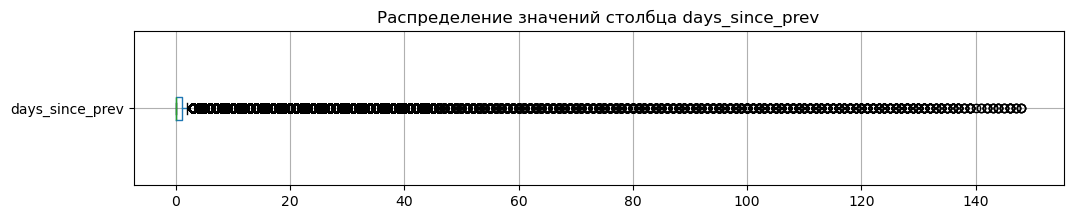

In [27]:
describe_data(['days_since_prev'])

В среднем повторные заказы совершаются раз в три дня. Распределение данных неравноемерное, сильно скошенное вправо, однако аномальных значений здесь нет, все выбросы обусловлены большим количеством частых ежедневных заказов.

### Выводы 
В результате предобработки данных были выполнены следующие действия:
- Был добавлен стобец revenue_rub с выручкой в единой валюте.
- Изучены пропуски в столбце days_since_prev.
- Была проведена оптимизация типов данных столбцов с численными данными order_id, event_id, tickets_count, а также оптимизация типов данных столбцов, хранящих дату и время.
- Данные проверили на явные и неявные дубликаты — в данных их нет.
- Были удалены выбросы в столбце revenue_rub.

In [28]:
display(f'Удалено строк: {strokes-df.shape[0]}')
display(f'Доля удаленных строк: {(strokes-df.shape[0])/strokes}')

'Удалено строк: 3336'

'Доля удаленных строк: 0.011479262656953797'

Такаим образом в процессе предобработки было потеряно 3336 строк, или 1.1% от всего объема данных.

## Создание профиля пользователя

Для будущего прогнозирования возврата пользователей удобно построить датафрейм, описывающий поведение и профиль каждого пользователя.

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 287275 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype        
---  ------                 --------------   -----        
 0   user_id                287275 non-null  object       
 1   device_type_canonical  287275 non-null  object       
 2   order_id               287275 non-null  int32        
 3   order_dt               287275 non-null  datetime64[s]
 4   order_ts               287275 non-null  datetime64[s]
 5   currency_code          287275 non-null  object       
 6   revenue                287275 non-null  float64      
 7   tickets_count          287275 non-null  int8         
 8   days_since_prev        265860 non-null  float64      
 9   event_id               287275 non-null  int32        
 10  service_name           287275 non-null  object       
 11  event_type_main        287275 non-null  object       
 12  region_name            287275 non-null  object       
 13  city

In [30]:
#Сортируем датафрейм по времени заказа
sorted_df = df.sort_values(by='order_ts')

df_users = (sorted_df
            .groupby('user_id')
            .agg(
                first_order_date=('order_dt', 'min'),
                last_order_date=('order_dt', 'max'),
                total_orders=('order_id', 'count'),
                avg_tickets=('tickets_count', 'mean'),
                avg_revenue_rub=('revenue_rub', 'mean'),
                avg_days_since_prev=('days_since_prev', 'mean'),
                first_region=('region_name', 'first'),
                first_service=('service_name', 'first'),
                first_event_type=('event_type_main', 'first'),
                first_device=('device_type_canonical', 'first')
            )
            .reset_index())

#Добавляем бинарные признаки
df_users['is_two'] = (df_users['total_orders'] >= 2).astype(int)
df_users['is_five'] = (df_users['total_orders'] >= 5).astype(int)

df_users_str =df_users.shape[0]

Изучим получившийся датафрейм `df_users`:

In [31]:
# Рассчитываем средние показатели
display(f'В выборку вошло {df_users.shape[0]} пользователей')
display(f"Средняя выручка с одного заказа на пользователя: {round(df_users['avg_revenue_rub'].mean(),2)}")
display(f"Средняя выручка с одного заказа: {round(((df_users['avg_revenue_rub']*df_users['total_orders']).sum())/(df_users['total_orders'].sum()),2)}")

# Рассчитываем доли пользователей
display(f"Доля пользователей, совершивших 2 и более заказов {round(df_users['is_two'].sum()/df_users.shape[0],3)}")
display(f"Доля пользователей, соверщивших 5 и более заказов {round(df_users['is_five'].sum()/df_users.shape[0],3)}")

'В выборку вошло 21713 пользователей'

'Средняя выручка с одного заказа на пользователя: 646.0'

'Средняя выручка с одного заказа: 569.52'

'Доля пользователей, совершивших 2 и более заказов 0.617'

'Доля пользователей, соверщивших 5 и более заказов 0.291'

Пользователи часто совершают повторные заказы, при этом только около трети клиентов совершают 5 или более покупок, нелояльными остается только около 10% от всех пользователей, предоставленных в выборке.
Средняя выручка с заказа на пользователя выше, чем средняя выручка с одного заказа, это может объясняться тем, что есть пользователи с небольшим количесвтом дорогих заказаов, которые смещают среднее значение.

Изучим статистические показатели, начнем с количества заказов:

In [32]:
# Описание столбца `total_orders`
display(df_users['total_orders'].describe())

count    21713.000000
mean        13.230553
std        122.204205
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      10195.000000
Name: total_orders, dtype: float64

Как видно по описанию столбца `total_orders`, в среднем пользователь совершает по 13.23 покупки за период исследования. Однако максимальное значение кажется аномально, проверим 99 процентиль:

In [33]:
display(df_users['total_orders'].quantile(0.99))

np.float64(151.88000000000102)

Значения, не првышающие 99% записей(151 заказ на пользователя) выглядят корректными, для фильтрации датафрейма удалим условные выбросы, превышающие по значению 99 процентиль.

In [34]:
# Удаляем выбросы
df_users = df_users[df_users['total_orders']<=(df_users['total_orders'].quantile(0.99))]

Теперь изучим столбец avg_tickets:

count    21495.000000
mean         2.753718
std          0.930343
min          1.000000
25%          2.000000
50%          2.760000
75%          3.142857
max         12.000000
Name: avg_tickets, dtype: float64

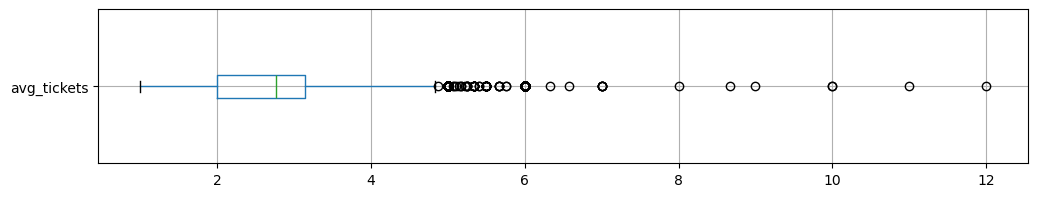

In [35]:
# Описание столбца `avg_tickets`
display(df_users['avg_tickets'].describe())
df_users.boxplot(column='avg_tickets', vert=False, figsize=(12,2))
plt.show()

Среднее количество билетов в заказе на пользователя совпадает со средним количеством билетов в заказе. На диаграмме распределения есть редкие выбросы с большими значениями, однако такие пользователи возможно представляют собой группу клиентов, совершающих корпоративные или групповые заказы, и такие данные не являются ошибочными.

Рассмотрим данные о среднем интервале между покупками:

In [36]:
# Выводим информацию о столбце avg_days_since_prev
display(df_users['avg_days_since_prev'].describe())

count    13241.000000
mean        16.263388
std         22.572334
min          0.000000
25%          1.411765
50%          8.500000
75%         21.000000
max        148.000000
Name: avg_days_since_prev, dtype: float64

Среднее значение количества дней между заказами на пользователя практически в 5 раз больше среднего, это обуславливается большим количеством пользователей, совершающих частые заказы, а также сравнительно небольшой частью пользователей, которые совершают заказы редко, однако ошибок в данных нет.

Изучим столбец со значениями средней выручки:

count    21495.000000
mean       646.935961
std        924.779218
min          0.000000
25%        220.620000
50%        484.806000
75%        812.353333
max      18048.810000
Name: avg_revenue_rub, dtype: float64

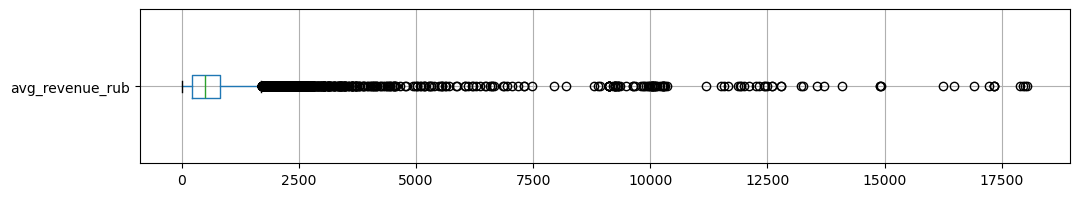

In [37]:
# Выводим информацию о столбце avg_revenue_rub
display(df_users['avg_revenue_rub'].describe())
df_users.boxplot(column='avg_revenue_rub', vert=False, figsize=(12,2))
plt.show()

Минимальная средняя выручка - 0, такие записи вероятно ошибочны, узнаем сколько таких строк в датафрейме:

In [38]:
# Найдем абсолютное и относительное количество записей с нулевой выручкой
display(df_users[df_users['avg_revenue_rub']==0]['avg_revenue_rub'].count())
display(df_users[df_users['avg_revenue_rub']==0]['avg_revenue_rub'].count()/df_users['user_id'].count())

np.int64(149)

np.float64(0.00693184461502675)

Всего 149(0.6% от общего количества) записей о пользователях с нулевой средней выручукой. 

Удалим такие записи:

In [39]:
# Удаляем записи с нулевой средней выручкой
df_users = df_users[df_users['avg_revenue_rub']>0]

При среднем значении средней выручки 651.45 и медианном 488.52 максимальное значение чуть выше 18000 выглядит аномально. По графику распределения видно, что условными выбросами в столбце являются все записи, превышающие примерно 1700. Проверим 99 процентиль:

In [40]:
avg_revenue_99p = df_users['avg_revenue_rub'].quantile(0.99)
display(avg_revenue_99p)

np.float64(3241.4434999999976)

Максимальное значение средней выручки превышает 99 процентиль практически в 6 раз, такие данные могут быть корректными, но так как цель анализа - исследование типичного поведения пользователей, стоит удалить такие записи 

In [42]:
df_users = df_users[df_users['avg_revenue_rub']<avg_revenue_99p]

Таким образом при фильтрации было удалено:

In [43]:
display(f'Удалено строк: {df_users_str-df_users.shape[0]}')
display(f'Доля удаленных строк: {(df_users_str-df_users.shape[0])/df_users_str}')

'Удалено строк: 581'

'Доля удаленных строк: 0.026758163312301388'

В процессе фильтрации был удален 2.7% строк, найдем показатели обновленного датафрейма:

In [45]:
# Рассчитываем обновленные средние показатели
display(f'В выборку вошло {df_users.shape[0]} пользователей')
display(f"Средняя выручка с одного заказа на пользователя: {round(df_users['avg_revenue_rub'].mean(),2)}")
display(f"Средняя выручка с одного заказа: {round(((df_users['avg_revenue_rub']*df_users['total_orders']).sum())/(df_users['total_orders'].sum()),2)}")

# Рассчитываем обновленные доли пользователей
display(f"Доля пользователей, совершивших 2 и более заказов {round(df_users['is_two'].sum()/df_users.shape[0],3)}")
display(f"Доля пользователей, соверщивших 5 и более заказов {round(df_users['is_five'].sum()/df_users.shape[0],3)}")

# Рассчитываем обновленные статистические данные
display(f"Среднее количество заказов на пользователя {round(df_users['total_orders'].mean(),3)}")
display(f"Среднее количество билетов в заказе на пользователя {round(df_users['avg_tickets'].mean(),3)}")
display(f"Среднее количество дней между заказами для пользователя {round(df_users['avg_days_since_prev'].mean(),3)}")

'В выборку вошло 21132 пользователей'

'Средняя выручка с одного заказа на пользователя: 582.07'

'Средняя выручка с одного заказа: 567.09'

'Доля пользователей, совершивших 2 и более заказов 0.617'

'Доля пользователей, соверщивших 5 и более заказов 0.287'

'Среднее количество заказов на пользователя 6.567'

'Среднее количество билетов в заказе на пользователя 2.758'

'Среднее количество дней между заказами для пользователя 16.246'

## Исследовательский анализ данных

### Исследование признаков первого заказа и их связи с возвращением на платформу

Для пониамния поведения пользователей на платформе исследуем признаки, описывающие первый заказ пользователя, и выясним, влияют ли они на вероятность возвращения пользователя.
Сгруппируем пользователей по типу их первого мероприятия:

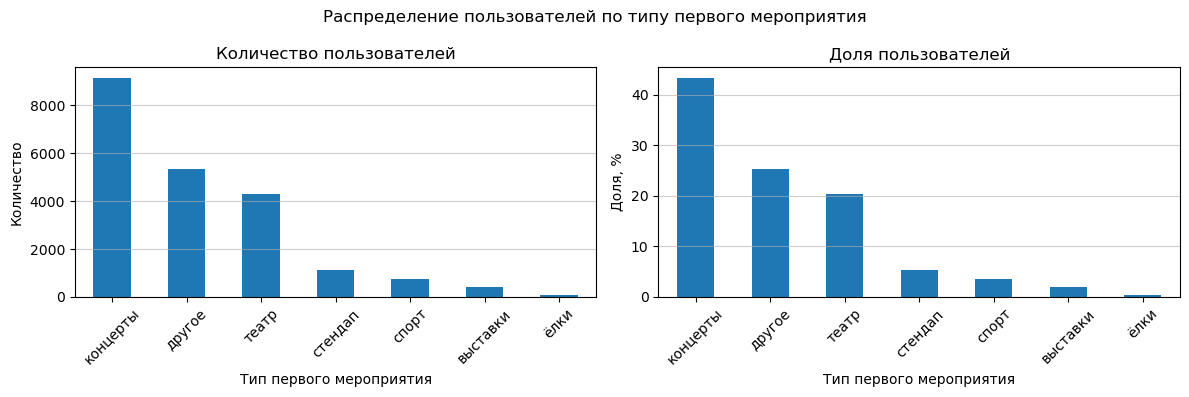

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

# Строим график по абсолютным значениям
df_users['first_event_type'].value_counts().plot(kind='bar', ax=axes[0], rot=45)
axes[0].set_title("Количество пользователей")
axes[0].set_xlabel("Тип первого мероприятия")
axes[0].set_ylabel("Количество")
axes[0].grid(axis='y', visible=True, alpha=0.6)

# Строим график по относительным значениям
(df_users['first_event_type'].value_counts(normalize=True)*100).plot(kind='bar', ax=axes[1], rot=45)
axes[1].set_title("Доля пользователей")
axes[1].set_xlabel("Тип первого мероприятия")
axes[1].set_ylabel("Доля, %")
axes[1].grid(axis='y', visible=True, alpha=0.6)

plt.suptitle('Распределение пользователей по типу первого мероприятия')
plt.tight_layout()
plt.show()

Распредение пользователей по типу первого мероприятия неравномерное,преобладающий тип мероприятия из первого заказа - концерты(более 40%). Около четверти первых мероприятий имеют тип 'другое', а пятая часть всех первых заказов - билеты в театр. По остальным типам мероприятий распределение более равномерное.

Теперь изучим сегментирование по типу первого устройства:

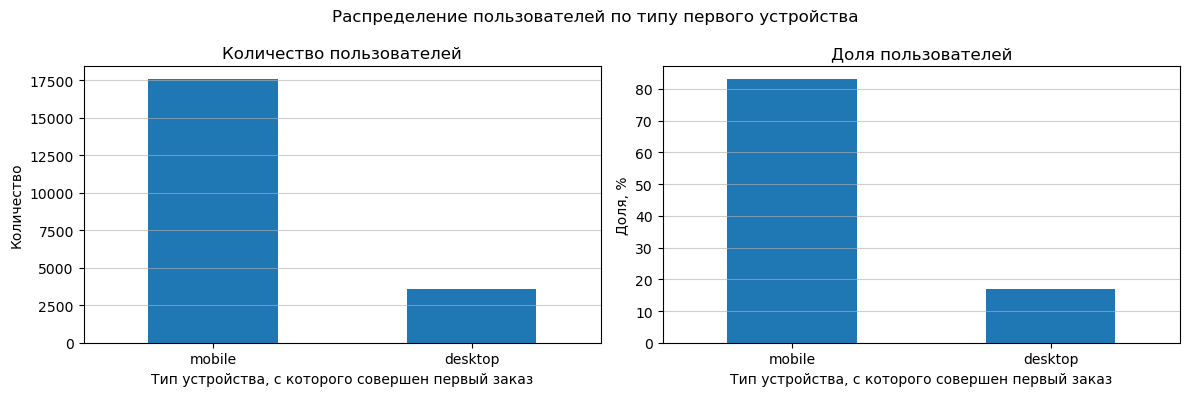

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

# Строим график по абсолютным значениям
df_users['first_device'].value_counts().plot(kind='bar', ax=axes[0], rot=0)
axes[0].set_title("Количество пользователей")
axes[0].set_xlabel("Тип устройства, с которого совершен первый заказ")
axes[0].set_ylabel("Количество")
axes[0].grid(axis='y', visible=True, alpha=0.6)

# Строим график по относительным значениям
(df_users['first_device'].value_counts(normalize=True)*100).plot(kind='bar', ax=axes[1], rot=0)
axes[1].set_title("Доля пользователей")
axes[1].set_xlabel("Тип устройства, с которого совершен первый заказ")
axes[1].set_ylabel("Доля, %")
axes[1].grid(axis='y', visible=True, alpha=0.6)

plt.suptitle('Распределение пользователей по типу первого устройства')
plt.tight_layout()
plt.show()

Более 80% пользователей совершают свой первый заказ через мобильное устройство, другие - через десктоп.

Рассмотрим сегментирование по регионам:

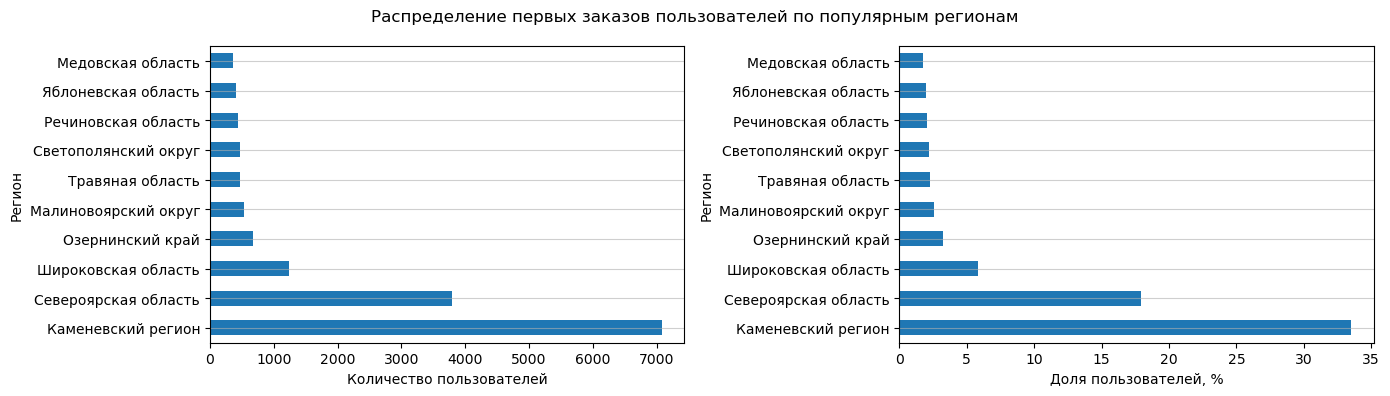

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(14,4))

# Строим график по абсолютным значениям
df_users['first_region'].value_counts().head(10).plot(kind='barh', ax=axes[0], rot=0)
axes[0].set_xlabel("Количество пользователей")
axes[0].set_ylabel("Регион")
axes[0].grid(axis='y', visible=True, alpha=0.6)

# Строим график по относительным значениям
(df_users['first_region'].value_counts(normalize=True)*100).head(10).plot(kind='barh', ax=axes[1], rot=0)
axes[1].set_xlabel("Доля пользователей, %")
axes[1].set_ylabel("Регион")
axes[1].grid(axis='y', visible=True, alpha=0.6)

plt.suptitle('Распределение первых заказов пользователей по популярным регионам')
plt.tight_layout()
plt.show()

По регионам первых заказов распределение также неравномерное: около 55% всех первых заказов совершено в Каменевском регионе, Североярской или Широковской областях.

Теперь изучим сегментирование по билетным операторам первого заказа:

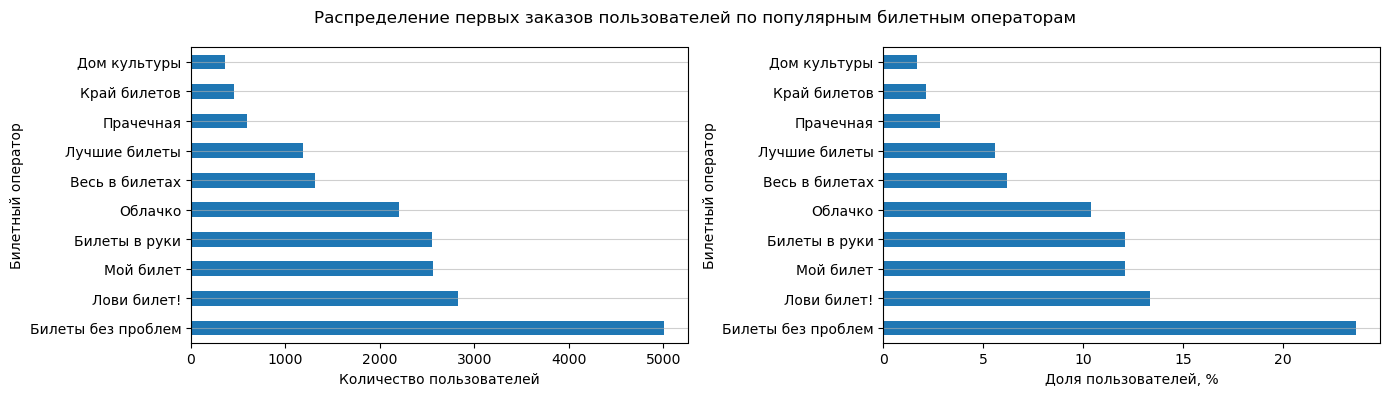

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(14,4))

# Строим график по абсолютным значениям
df_users['first_service'].value_counts().head(10).plot(kind='barh', ax=axes[0], rot=0)
axes[0].set_xlabel("Количество пользователей")
axes[0].set_ylabel("Билетный оператор")
axes[0].grid(axis='y', visible=True, alpha=0.6)

# Строим график по относительным значениям
(df_users['first_service'].value_counts(normalize=True)*100).head(10).plot(kind='barh', ax=axes[1], rot=0)
axes[1].set_xlabel("Доля пользователей, %")
axes[1].set_ylabel("Билетный оператор")
axes[1].grid(axis='y', visible=True, alpha=0.6)

plt.suptitle('Распределение первых заказов пользователей по популярным билетным операторам')
plt.tight_layout()
plt.show()

Самый популярный билетный оператор, продавший около 24% билетов на первый заказ - "Билеты без проблем", еще 4 популярных оператора("Облачко","Билеты в руки", "Мой билет","Лови билет!") продают более 40% первых билетов.

Пользователи неравномерно распределены по сегментам, существуют выраженные точки входа, которые можно описать так: 
- при первом заказе пользователь чаще всего покупает билет на концерт или на мероприятие с пометкой "другое",
- самый распространенный оператор "Билеты без проблем",
- чаще первый заказ пользователь совершает с телефона,
- первый заказ обычно происходит в Каменевском регионе, Североярской или Широковской областях.

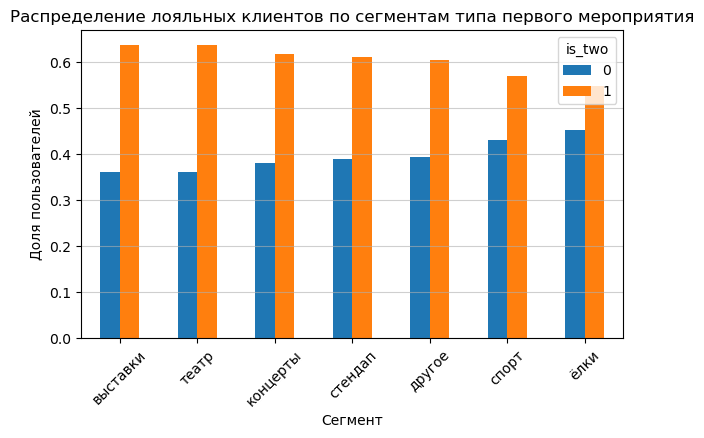

In [50]:
# Сгруппируем данные по типу первого мероприятия
type_segments = df_users.groupby('first_event_type')['is_two'].value_counts(normalize=True).unstack(fill_value=0)

# Построим столбчатую диаграмму распределения лояльных и нелояльных клиентов
type_segments.sort_values(0).plot(kind='bar',
                                  figsize=(7,4), rot=45,
                                  title='Распределение лояльных клиентов по сегментам типа первого мероприятия',
                                  xlabel = 'Сегмент',
                                  ylabel = 'Доля пользователей')
                                                                                                            
plt.grid(axis='y', visible=True, alpha=0.6)                                                                                                                 
plt.show()

Внутри сегментов распределение схожее: ококло 55-63% пользователей совершают повторный заказ, наибольшая доля лояльных клиентов у пользователей, впервые посетивших выставки и театры, наименьшая - у посетителей ёлок.

Изучим распределение лояльных клиентов по сегментам первого устройства для заказа:

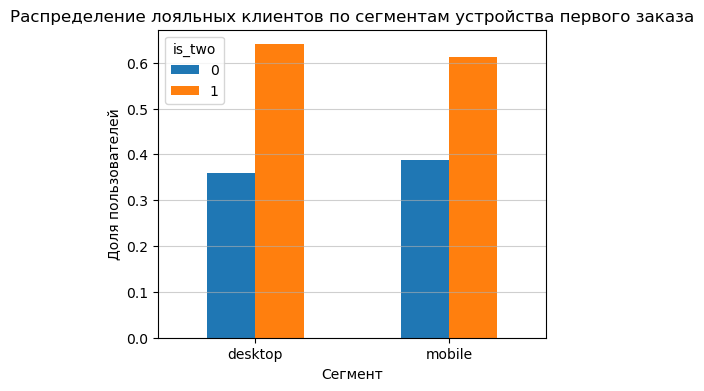

In [51]:
# Группируем пользователей по типу первого устройстройства для заказа
device_segments = df_users.groupby('first_device')['is_two'].value_counts(normalize=True).unstack(fill_value=0)

# Построим столбчатую диаграмму распределения лояльных и нелояльных клиентов
device_segments.sort_values(0).plot(kind='bar',
                                  figsize=(5,4), rot=0,
                                  title='Распределение лояльных клиентов по сегментам устройства первого заказа',
                                  xlabel = 'Сегмент',
                                  ylabel = 'Доля пользователей')
                                                                                                            
plt.grid(axis='y', visible=True, alpha=0.6)                                                                                                                 
plt.show()

Чаще возвращаются пользователи, совершившие свой первый заказ с десктопного устройства (около 63% лояльных), однако доля лояльных клиентов, совершивших свой первый заказ с мобильного устройства тоже высока - около 60%.

Рассмотрим респределение по регионам:

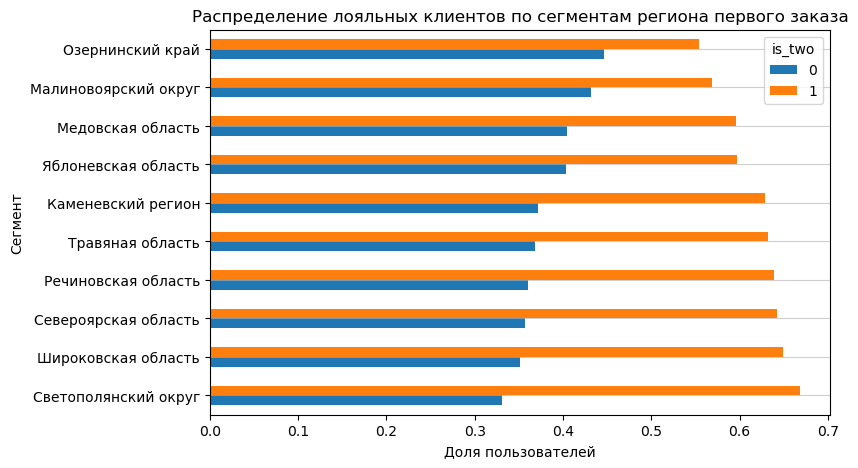

In [52]:
# Находим 10 самых популярных регионов для первого заказа и группируем данные
top10_regions = df_users['first_region'].value_counts().head(10).reset_index()
# Столбец с регионами теперь называется 'index', а не 'first_region'
region_segments = df_users[df_users['first_region'].isin(top10_regions['first_region'])].groupby('first_region')['is_two'].value_counts(normalize=True).unstack(fill_value=0)

# Построим столбчатую диаграмму распределения лояльных и нелояльных клиентов
region_segments.sort_values(0).plot(kind='barh',
                                  figsize=(8,5), rot=0,
                                  title='Распределение лояльных клиентов по сегментам региона первого заказа',
                                  ylabel = 'Сегмент',
                                  xlabel = 'Доля пользователей')
                                                                                                            
plt.grid(axis='y', visible=True, alpha=0.6)                                                                                                                 
plt.show()

В трех самых популярных сегментах пользователей по регионам первого заказа(Каменевский регион, Североярская и Широковская области) доля лояльных клиентов примерно равна - около 64% пользователей совершают повторные покупки. Наибольлшая доля лояльных клиентов(около 66%) наблюдается у пользователей, совершивщих первый заказ в Светополянском округе. Доля лояльных клиентов в остальных больших сегментах варьируется от 55 до 63%.

Рассмотрим распределение лояльных пользователей по сегментам оператора первого заказа:

In [53]:
#Находим 10 самых популярных сервисов и группируем по ним заказы
top10_services = df_users['first_service'].value_counts().head(10).reset_index()
service_segments = df_users[df_users['first_service'].isin(top10_services['index'])].groupby('first_service')['is_two'].value_counts(normalize=True).unstack(fill_value=0)

# Построим столбчатую диаграмму распределения лояльных и нелояльных клиентов
service_segments.sort_values(0).plot(kind='barh',
                                  figsize=(8,5), rot=0,
                                  title='Распределение лояльных клиентов по сегментам оператора первого заказа',
                                  ylabel = 'Сегмент',
                                  xlabel = 'Доля пользователей')
                                                                                                            
plt.grid(axis='y', visible=True, alpha=0.6)                                                                                                                 
plt.show()

KeyError: 'index'

Доля лояльных клиентов по сегментам распределяется схоже: от 59 до 65% клиентов совершают повторные покупки.Стоит отметить, что у наиболее популярных сегментов доля лояльных клиентов в среднем ниже, чем у других, то есть клиенты возвращаются чаще, если совершают первую покупку у не самых популярных операторов("Край билетов" или "Дом культуры").

Чаще других лояльными становятся клиенты, которые прошли через следующие "точки входа":
- купили первые билеты в театр или на выставку,
- совершили первый заказ с десктопного устройства,
- сделали первый заказ из распространенных регионов первого заказа,
- приобрели билеты у вторых по популярности операторов.



**Проверим выдвинутые продуктовые гипотезы:**

*Гипотеза 1.* Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
 
Тип первого мероприятия действительно влияет на вероятность возврата, однако гипотеза не подтверждается, так как по графику распределения доли лояльных клиентов по типу первого мероприятия видно, что лояльными клиентами чаще становятся пользователи, совершившие заказ на концерт - около 63% возвращаются, в то время как пользователи, совершившие заказ на спортивные мероприятия возвращаются только в примерно 56% случаев.

*Гипотеза 2.* В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

Гипотеза подтверждается не полностью, так как в среднем пользователи популярных регионов действительно возвращаются чаще, чем пользователи других регионов:
- в Каменевском регионе и в Североярской области около 64%,
- в Широковской области приблизительно 65%.
Однако по относительному значению лояльных клиентов лидирует не самый популярный Светополянский округ - 66% вернувшихся клиентов, в других же регионах относительно значение ниже указанных.

## Исследование поведения пользователей через показатели выручки и состава заказа

Изучим количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают. Для начала рассчитаем среднюю выручку сервиса 

In [ ]:
loyal_users = df_users[df_users['is_two']==1]
unloyal_users = df_users[df_users['is_two']==0]

display(f"Средняя выручка с одного заказа на лояльного пользователя: {round(loyal_users['avg_revenue_rub'].mean(),2)}")
display(f"Cреднее количество билетов в заказе у лояльного пользователя: {round(loyal_users['avg_tickets'].mean(),2)}")

display(f"Средняя выручка с одного заказа на нелояльного пользователя: {round(df_users[df_users['is_two']==0]['avg_revenue_rub'].mean(),2)}")
display(f"Cреднее количество билетов в заказе у нелояльного пользователя: {round(unloyal_users['avg_tickets'].mean(),2)}")


Средний чек нелояльных клиентов в среднем выше чека вернувшихся клиентов на 6%. Разница между средним количеством билетов в заказе незначительна.

Проверим гипотезу: Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются. 

Для этого построим сравнительную гистограмму распределения плотности вероятности средней выручки:

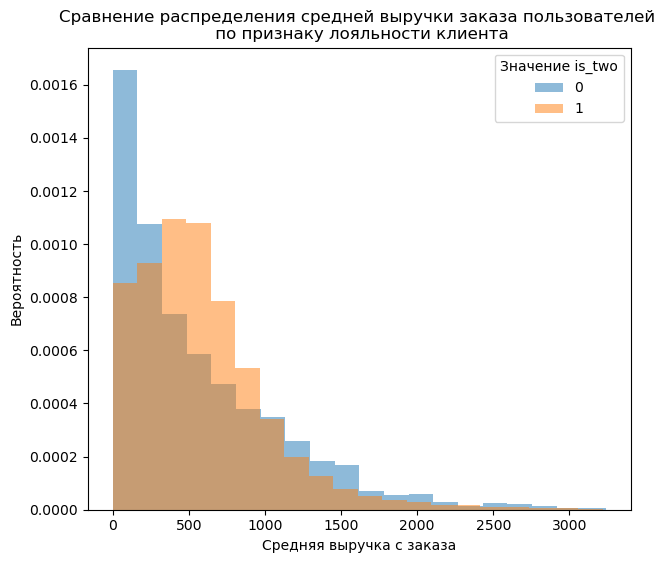

In [54]:
plt.figure(figsize=(7, 6))

# Строим гистограммы для каждого значения is_two
for i in df_users['is_two'].unique():
    df_users[df_users['is_two'] == i]['avg_revenue_rub'].plot(kind='hist',
                                                              bins=20,
                                                              alpha=0.5,
                                                              density=True,
                                                              label=f'{i}',
                                                              legend=True)

# Настраиваем внешний вид графика и выводим его на экран
plt.title('Сравнение распределения средней выручки заказа пользователей \n по признаку лояльности клиента')
plt.xlabel('Средняя выручка с заказа')
plt.ylabel('Вероятность')
plt.legend(title='Значение is_two')
plt.show()

По гистограмме распределения видно, что пользователи совершившие заказ в среднем на 250-1000 рублей возвращаются на платформу. Пользователи совершившие дешевые заказы до 250 рублей чаще нелояльны. 
Среди клиентов со средней выручкой с заказа от 1000 до 3000 четко выражена тенденция реже возвращаться на платформу.

Гипотеза не подтвердилась, пользователи со средним чеком чуть ниже среднего более заинтересованы в платформе, а по мере увеличения среднего чека доля нелояльных клиентов возрастает.

Сравним распределение по средней выручке с заказа в двух группах пользователей:
- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

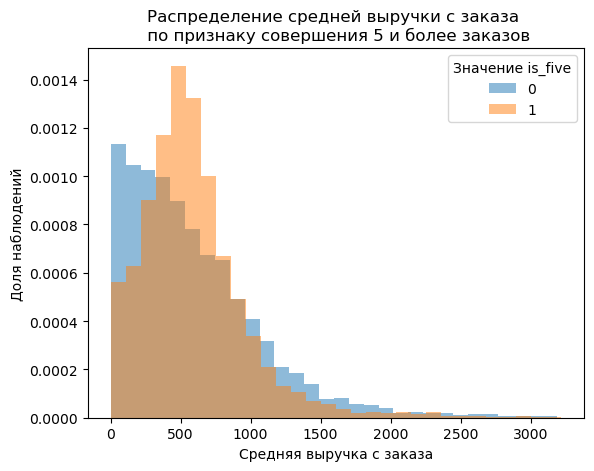

'Средний чек пользователей, совершивщих 2-4 покупки: 590.44'

'Средний чек пользователей, совершивших 5 и более покупок: 589.02'

In [55]:
# Строим гистограммы для каждой группы пользователей
for i in df_users['is_two'].unique():
    df_users[(df_users['is_two'] == 1) & (df_users['is_five']==i) ]['avg_revenue_rub'].plot(kind='hist',
                                                                                            bins=30,
                                                                                            density = True,
                                                                                            alpha=0.5,
                                                                                            label=f'{i}',
                                                                                            legend=True)

# Настраиваем внешний вид графика и выводим его на экран
plt.title(f'Распределение средней выручки с заказа \n по признаку совершения 5 и более заказов')
plt.xlabel('Средняя выручка с заказа')
plt.ylabel('Доля наблюдений')
plt.legend(title='Значение is_five')
plt.show()

display(f"Средний чек пользователей, совершивщих 2-4 покупки: {round(df_users[(df_users['is_two'] == 1) & (df_users['is_five']==0) ]['avg_revenue_rub'].mean(0),2)}")
display(f"Средний чек пользователей, совершивших 5 и более покупок: {round(df_users[(df_users['is_two'] == 1) & (df_users['is_five']==1) ]['avg_revenue_rub'].mean(0),2)}")

Чаще пользователи совершают 5 и более заказов со средней выручкой с заказа до 900 рублей, а значит чаще возвращаются пользователи со сравнительно недорогими заказами.

Изучим распределение среднего количества билетов в заказе:

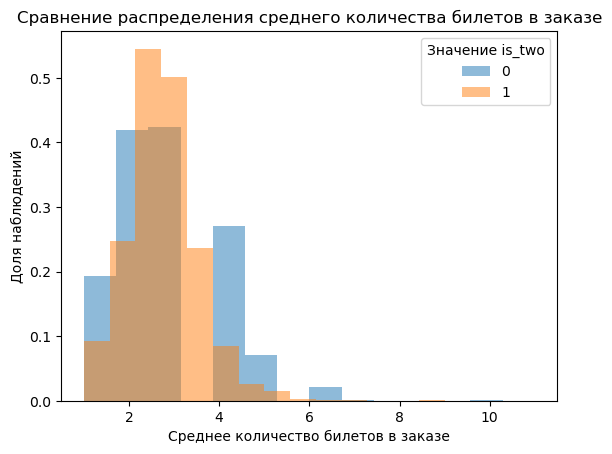

In [56]:
# Строим гистограмму распределения для лояльных и нелояльных пользователей
for i in df_users['is_two'].unique():
    df_users[(df_users['is_two'] == i)]['avg_tickets'].plot(kind='hist',
                                                            alpha=0.5,
                                                            label=f'{i}',
                                                            density=True,
                                                            bins = 14,
                                                            legend=True)

# Настраиваем гистограмму
plt.title(f'Сравнение распределения среднего количества билетов в заказе')
plt.xlabel('Cреднее количество билетов в заказе')
plt.ylabel('Доля наблюдений')
plt.legend(title='Значение is_two')
plt.show()

По гистограмме можно сделать вывод о том, что чаще возвращаются на платформу клиенты, в среднем совершившие заказы на 2-3 билета. Чем больше билетов в заказе тем более редкими становятся возвращения на платформу.

Разделим пользователей на несколько сегментов по среднему количеству билетов в заказе:
- от 1 до 2 билетов;
- от 2 до 3 билетов;
- от 3 до 5 билетов;
- от 5 и более билетов.

In [57]:
# Функция для разделения пользователей по сегментам
def tickets_range(row):
    if row['avg_tickets']>=1 and row['avg_tickets']<2:
        return 'от 1 до 2 билетов'
    elif row['avg_tickets']>=2 and row['avg_tickets']<3:
         return 'от 2 до 3 билетов'
    elif row['avg_tickets']>=3 and row['avg_tickets']<5:
         return 'от 3 до 5 билетов'
    elif row['avg_tickets']>=5:
        return 'от 5 и более билетов'
    else:
        return 'unknown'

#Применяем функцию
df_users['tickets_segment']=df_users.apply(tickets_range, axis=1)

Теперь рассчитаем абсолютное и относительное количество вернувшихся пользователей:

In [58]:
# Агрегируем данные
segment_stats = df_users.groupby('tickets_segment').agg(total_users=('user_id', 'count'),loyal_users=('is_two', 'sum'))

# Рассчитываем дополнительные значения
segment_stats['unloyal_users'] = (segment_stats['total_users']-segment_stats['loyal_users'])
segment_stats['loyalty_rate, %'] = (segment_stats['loyal_users'] / segment_stats['total_users'] * 100).round(2)

#Выводим таблицу с агрегированными значениями
display(segment_stats)

# Удаляем созданный столбец
del df_users['tickets_segment']

,total_users,loyal_users,unloyal_users,"loyalty_rate, %"
tickets_segment,,,,
от 1 до 2 билетов,2311,1194,1117,51.67
от 2 до 3 билетов,9206,6786,2420,73.71
от 3 до 5 билетов,8947,4938,4009,55.19
от 5 и более билетов,668,131,537,19.61


Пользователи неравномерно распределены по сегментам, чаще всего пользователи покупают от 2 до 5 билетов в заказе, больших же заказов меньше всего.

Пользователи, купившие от 2 до 3 билетов возвращаются чаще остальных на 20%, а при покупке до 2 или от 3 до 5 билетов пользователи с равной вероятностью становятся лояльными.

Аномально низкая доля повторных покупок у пользователей, совершивших большие заказы(5 и более билетов), возможно это корпоративные или групповые заказы, которые часто носят единоразовый характер.

In [59]:
df_users['first_order_dow'] = df_users['first_order_date'].dt.day_of_week

# Агрегируем данные
dow_stats = df_users.groupby('first_order_dow').agg(total_users=('user_id', 'count'), loyal_users=('is_two', 'sum'))

# Рассчитываем дополнительные значения
dow_stats['unloyal_users'] = (dow_stats['total_users']-dow_stats['loyal_users'])
dow_stats['loyalty_rate, %'] = (dow_stats['loyal_users'] / dow_stats['total_users'] * 100).round(2)

display(dow_stats)
# Удаляем созданный столбец
del df_users['first_order_dow']

,total_users,loyal_users,unloyal_users,"loyalty_rate, %"
first_order_dow,,,,
0,2797,1767,1030,63.17
1,3030,1877,1153,61.95
2,2982,1859,1123,62.34
3,3085,1860,1225,60.29
4,3208,1945,1263,60.63
5,3281,2074,1207,63.21
6,2749,1667,1082,60.64


День недели первого заказа не оказывает сильного влияния на вероятность повторного заказа, процентные доли вернувшихся клиентов различаются всего на 2.5%.

Изучим, как средний интервал между заказами влияет на удержание клиентов. Для начала рассчитаем среднее время между заказами для двух групп пользователей:
- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

In [60]:
display(df_users[df_users['is_two']==1].groupby('is_five')['avg_days_since_prev'].mean())

is_five
0    21.481817
1     9.960080
Name: avg_days_since_prev, dtype: float64

Средний промежуток между заказами у пользователей, совершивших 2-4 заказа - 21.42 день, и вполне ожидаемо, у пользователей, совершивших больше 5 заказов средний промежуток в 2 раза меньше - 9.95 дней.

Теперь исследуем, как средний интервал между заказами влияет на вероятность повторного заказа:

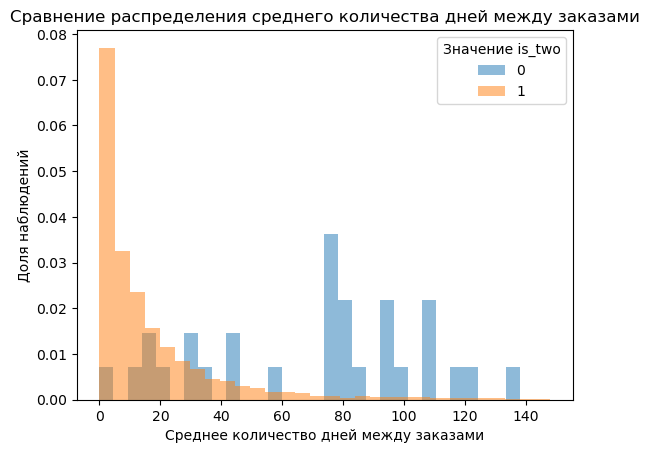

In [61]:
# Строим гистограмму распределения количества дней между заказами' для лояльных и нелояльных пользователей
for i in df_users['is_two'].unique():
    df_users[(df_users['is_two'] == i)]['avg_days_since_prev'].plot(kind='hist',
                                                            alpha=0.5,
                                                            label=f'{i}',
                                                            density=True,
                                                            bins = 30,
                                                            legend=True)

# Настраиваем гистограмму
plt.title(f'Сравнение распределения среднего количества дней между заказами')
plt.xlabel('Cреднее количество дней между заказами')
plt.ylabel('Доля наблюдений')
plt.legend(title='Значение is_two')
plt.show()

По гистограмме распределения можно сделать вывод, что лояльные пользователи совершают повторный заказ в течении 30 дней, при превышении этого интервала вероятность возврата клиента на платформу резко снижается.

Проведем корреляционный анализ: рассчитаем коэффициент корреляции phi_k между признаками профиля пользователя и числом заказов (total_orders):

In [62]:
# Определяем интервальные переменные
interval_columns = ['total_orders', 'avg_tickets', 'avg_revenue_rub', 'avg_days_since_prev']

# Вычисляем корреляционную матрицу с использованием phi_k с указанием интервальных колонок
correlation_matrix = df_users[['total_orders', 'avg_tickets', 'avg_revenue_rub', 
                               'avg_days_since_prev', 'is_two','is_five', 'first_event_type',
                               'first_device', 'first_service']].phik_matrix(interval_cols=interval_columns)

# Выводим результат
display('Корреляционная матрица с коэффициентом phi_k для переменной total_orders')
display(correlation_matrix.loc[correlation_matrix.index != 'total_orders'][['total_orders']].sort_values(by='total_orders', ascending=False))

'Корреляционная матрица с коэффициентом phi_k для переменной total_orders'

,total_orders
is_five,0.637994
is_two,0.321532
avg_days_since_prev,0.299544
avg_tickets,0.227950
avg_revenue_rub,0.216951
first_service,0.042211
first_event_type,0.024843
first_device,0.022346


Самая высокая корреляция наблюдается со столбцами is_five и is_two, что объясняется логической связью бинарных признаков и количеством заказов. 
Умеренная корреляция у столбца total_orders существует со столбцами avg_days_since_prev,  avg_revenue_rub и avg_tickets.

Многие значения корреляции близки к нулю, проверим разброс данных в tickets_count:

In [63]:
# Описание данных столбца total_orders
display(df_users['total_orders'].describe())

count    21132.000000
mean         6.567291
std         14.349622
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        151.000000
Name: total_orders, dtype: float64

Такое распределение с сильным перевесом на 1-2 заказа может вызывать заниженную корреляцию, для того чтобы оценить взаимосвязи следует сегментировать пользователей по количеству заказов:
- 1 заказ;
- от 2 до 4 заказов;
- от 5 и выше.

In [ ]:
# Функция для построения корреляционной матрицы и тепловой карты
def heatmap_corr_matrix(data, stroke_title):
    correlation_matrix = data[['total_orders', 'avg_tickets', 'avg_revenue_rub', 
                               'avg_days_since_prev', 'first_event_type',
                               'first_device', 'first_service']].phik_matrix(interval_cols=interval_columns)
    display('Корреляционная матрица с коэффициентом phi_k для переменной total_orders')
    corr_matrix = correlation_matrix.loc[correlation_matrix.index != 'total_orders'][['total_orders']].sort_values(by='total_orders', ascending=False)
    display(corr_matrix)
    plt.figure(figsize=(2, 4))
    sns.heatmap(corr_matrix, 
            annot=True,
            fmt='.2f', 
            cmap='rocket',
            linewidths=0.5,
            cbar=False)
    plt.title(f'Тепловая карта коэффициента phi_k \n для данных total_orders {stroke_title}')
    plt.show()

# Вызов функции для сегмента total_orders=1
heatmap_corr_matrix(df_users[df_users['total_orders']<=2], '< 2')

Для сегмента пользователей, совершивших до 2 заказов существует слабая взаимосвязь с данными avg_tickets, avg_revenue_rub и avg_days_since_prev, которая почти в 2 раза слабее корреляции, отмеченной для всех данных.

In [ ]:
# Вызов функции для сегмента 1 < total_orders < 5 
heatmap_corr_matrix(df_users[(df_users['total_orders']>2) & (df_users['total_orders']<5)], 'от 2 до 4')

Наблюдается взаимосвязь только с avg_days_since_prev, avg_revenue_rub и avg_tickets, которая по коэффициенту совпадает с данными общей матрицы корреляции, так как исследуемый сегмент является самым популярным.

In [ ]:
# Вызов функции для сегмента total_orders>=5
heatmap_corr_matrix(df_users[df_users['total_orders']>=5], 'от 5 и выше')

Для большого количества заказов наблюдается сильная взаимосвязь с данными avg_days_since_prev и слабая корреляция c  avg_revenue_rub и avg_tickets. С другими статистическими данными корреляции нет.

Подводя итоги, боллее всего с количеством заказов взаимосвязаны среднее количество дней между заказами и среднее количество покупаемых билетов.

## Общие выводы и рекомендации

В ходе исследования проанализировали данные 290611 строк, в которых представлена информация о заказах пользователе Яндекс Афиши. Данные включали информацию о пользователе, совершившим заказ, егог дате, регионе, выручке. Акцент исследования был на том, чтобы найти лучше понимать поведение пользователей и понять какие из них чаще возвращаются на платформу.

Для дальнейшей работы была проведена предобработка данных, в ходе которой было отфильтровано 3290 строк, а также добавлен столбец revenue_rub, в котором выручка с каждого заказа переведена в рубли. 

После предобработки был сформирован датафрейм, отображающий профиль каждого пользователя, состоящий из агрегированных признаков, описывающие поведение пользователя. Всего в него вошло 21713 пользователей, после изучения получившихся показателей было отфильтровано 218 выбросов по общему количеству заказов. 

Большинство пользователей совершили на платформе 2-4 заказа, постоянных клиентов, совершивших 5 и более покупок всего 25%, в среднем в заказ входит около 3 билетов.

Чаще других лояльными становятся клиенты, которые прошли через следующие "точки входа":
- купили первые билеты в театр или на выставку,
- совершили первый заказ с десктопного устройства,
- сделали первый заказ из распространенных регионов первого заказа,
- приобрели билеты у вторых по популярности операторов.

Более лояльны клиенты, со средней выручкой с заказа от 250-1000 рублей и от 3000-7500. При этом средняя выручка среди клиентов совершивших 2-4 заказа 659.39, а для пользователей с 5 и более заказами - 600.91.

Самая высокаа доля лояльных клиентов (73.4%) наблюдается у пользователей со средним количеством билетов в заказе от 2 до 3.

День недели совершения первого заказа значительно на возвращение клиента не влияет. Однако среди временных характеристик можно выделить средний интервал между покупками: если пользователь не совершает повторный заказ в течении 30 дней, то это повышает риск оттока.

Взаимосвязь с числом покупок наблюдается только у среднего количества билетов в заказе и среднего интервала между заказами, при этом матрица корреляции показывает, что нет четкой связи между средней выручкой и количеством заказов.


Общие рекомендации:
- делать специальные предложения клиентам на приобритение 2-3 билетов - пользователи с таким средним количеством билетов возвращаются в 75% случаев,
- организовать рассылку со специальными предложениями для пользователей, с интервалом в 25 дней с момента последней покупки, так как после интервала между покупками выше 30 дней клиенты возвращаются значительно реже.

**Ссылка на репозиторий: https://github.com/ksusamohval/yandex_afisha**